### Сборный проект 2 стартап по продаже продуктов питания

<b>Описание проекта</b>
<br>Цель:</br>
<br>Изучить, воронку продаж. <br>Узнать, как пользователи доходят до покупки.</br> <br>Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах?</br> 
<br>На каких именно шагах?</br>
<br>Исследовать результаты A/A/B-эксперимента. По изменению шрифтов во всём приложении.</br>
<br></br>
<br><b>Описание данных</b></br>
<br>Каждая запись в логе — это действие пользователя, или событие.</br>
<br>EventName — название события;</br>
<br>DeviceIDHash — уникальный идентификатор пользователя;</br>
<br>EventTimestamp — время события;</br>
<br>ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.</br>


In [1]:
#Импортируем все необходимые библиотеки для работы 
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.simplefilter('ignore')

<b><br>Открываем файл с данными и изучаем общую информацию</br></b>

In [2]:
lags = pd.read_csv('/datasets/logs_exp.csv',sep='\t')

In [3]:
lags.info()
lags.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Датасет имеет 4 колонки и 244126 записей. Видно что колонка EventTimestamp имеет неверный тип данных, как и ExpId,DeviceIDHash. На первы взгляд пропусков в датасете нет, но нужно проверить.

<b>Подготовка данных.</b> 

In [4]:
#Переименуем столбцы в более понятные, для удобства анализа 
lags.columns = ['event_name', 'device_id', 'datetime', 'group_id']

In [5]:
#Проверяем переименование
lags.head(5)

,event_name,device_id,datetime,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
#Меняем типы данных в колонках на нужные.
lags['datetime'] = pd.to_datetime(lags['datetime'], unit='s')
lags['device_id'] = lags['device_id'].astype(str)
lags['group_id'] = lags['group_id'].astype(str)
lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  object        
 2   datetime    244126 non-null  datetime64[ns]
 3   group_id    244126 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 7.5+ MB


In [7]:
#проверяем на наличие дубликаотов датасет 
display(lags.duplicated().sum())

413

In [8]:
#проверяем на наличие пропусков датасет 
lags.isna().sum()

event_name    0
device_id     0
datetime      0
group_id      0
dtype: int64

In [9]:
#Удаляем дубликаты из датасета
lags = lags.drop_duplicates()
lags

,event_name,device_id,datetime,group_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [10]:
#Добавляем столбец с датой
lags['date'] = lags['datetime'].dt.date

In [11]:
#Проверим пересечение пользователей в каждой группе 
lags_group_user = lags.groupby('device_id')['group_id'].nunique().reset_index().query('group_id > 1')
lags_group_user

,device_id,group_id


В датасете были обнаружены 413 дубликатов, их не много и было принято решение удалить дубликаты для более точного анализа. Так же изменили типы данных в колонках с датой на привычный datatime, и в колонках с названием группы и id устройства на obj, для удобного счёта. Пропусков в датасете нет. Так же проверили попадание одних и тех же пользователей в 2 или 3 группы сразу, результат оказался отрицательным, т.е. все пользователи распределяются равномерно по группам без дубля. 

<b>Изучение и проверка данных</b>

In [12]:
# Считаем количество уникальных событий в колонке event_name в датасете lags
print('Всего: Событий',len(lags['event_name'].value_counts()))

Всего: Событий 5


In [13]:
# Считаем количество пользователей в датасете 
print('Всего: Пользователей',len(lags['device_id'].value_counts()))

Всего: Пользователей 7551


In [14]:
#Посмотрим на количество событий по их видам 
lags['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [15]:
#Среднее значение события на 1 пользователя 
avg_events_person = lags.pivot_table(index='device_id',values='event_name',aggfunc=('count'))
print('В среднем на пользователя приходится', round(avg_events_person['event_name'].mean(), 1), 'события')

В среднем на пользователя приходится 32.3 события


In [16]:
# Находим минимальную и максимальную даты 
min_date = lags['date'].min()
max_date = lags['date'].max()
print('Даты:\nМинимум: {}\nМаксимум: {}'
      .format(min_date,max_date))

Даты:
Минимум: 2019-07-25
Максимум: 2019-08-07


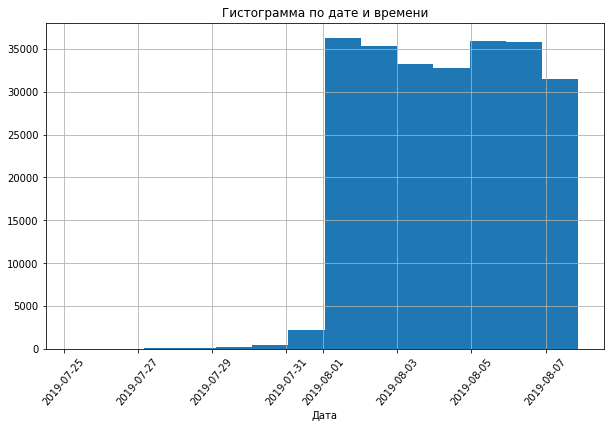

In [17]:
#Гитограмма по дате и времени
plt.figure(figsize=(10,6))
lags['datetime'].hist(bins = 14).set_title('Гистограмма по дате и времени')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

По графику видно что наименьшее число событий приходиться на даты с 25-07-2019 по 01-08-2019. И основная часть событий приходится на период с 1 вгуста по 7 августа. Я думаю этот период с данными нам и понадобится для анализа.

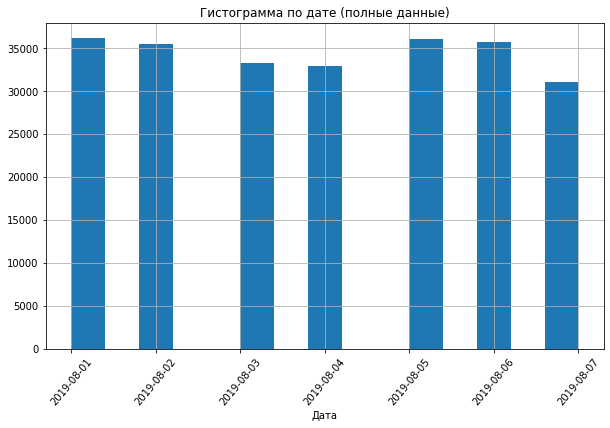

In [18]:
# Отбросим события до 1 августа, строим гистограмму для подробного изучения 
lags['date'] = pd.to_datetime(lags['date'])
сomplete_data = lags.query('date > "2019-07-31"')
plt.figure(figsize=(10,6))
сomplete_data['date'].hist(bins=15).set_title('Гистограмма по дате (полные данные)')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

Данные за период 25-07-2019 по 01-08-2019 были отброшены, т.к. их было недостаточно для анализа. Основной блок с данными расположился с 1 по 7 августа, данный период и будем считать полными данными и использовать для анализа. Так же нужно посмотреть какую часть данных мы в итоге отбросили от общего датасета и не повлияет ли это на дальнейший анализ.

In [19]:
#Посмотрим какое соотношение полных данных к всему датасету.
#Создаю новые датасеты с фильтрацией и без.
old_data = lags 
сomplete_data #датасет с фильтром создан ранее

#Смотрим общее количество данных в датасете без фильтра.
old_data.shape[0]

243713

In [20]:
#Смотрим на соотношение отфильтрованых и неотфильтрованых данных 
round(сomplete_data.shape[0]/old_data.shape[0]*100,2)

98.84

In [21]:
#Смотрим на потери пользователей после фильтрации
filter_users = len(сomplete_data['device_id'].value_counts())
unfiltered_users = len(lags['device_id'].value_counts())
print('Количество пользователей до фильтрации : {}, \nпосле фильтрации : {}. \nРазность : {} или {}%'
      .format(unfiltered_users, filter_users,unfiltered_users - filter_users,
       round(100 - filter_users/unfiltered_users*100, 2)))

Количество пользователей до фильтрации : 7551, 
после фильтрации : 7534. 
Разность : 17 или 0.23%


In [22]:
#Проверяем, что в отфильтрованный датасет попали все 3 группы
сomplete_data['group_id'].value_counts()

248    84563
246    79302
247    77022
Name: group_id, dtype: int64

В целом согласно посчитаным данным мы немного потеряли благодаря фильтру с датой, по общей картине это 1.2 % от общего количества данных и 0,23 % от количества пользователей. Теперь анализ будет куда точнее с этими правками. Так же видно что все 3 контрольные группы попали в анализ. 

<b>Изучаем воронку событий</b>

In [23]:
#Смотрим на то, какие события есть в логах, и как часто они встречаются. Сортируем события по частоте.
сomplete_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [24]:
#Считаем, сколько пользователей совершали каждое из этих событий. 
#Сортируем события по числу пользователей. 
user_per_event = сomplete_data.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(by='device_id',ascending=False)
user_per_event

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [25]:
#Считаем долю пользователей, которые хоть раз совершали событие.
user_per_event['%'] = round(user_per_event['device_id']/len(сomplete_data['device_id'].unique()), 3) * 100
user_per_event.columns = ['device_id','%']
user_per_event

,device_id,%
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.1


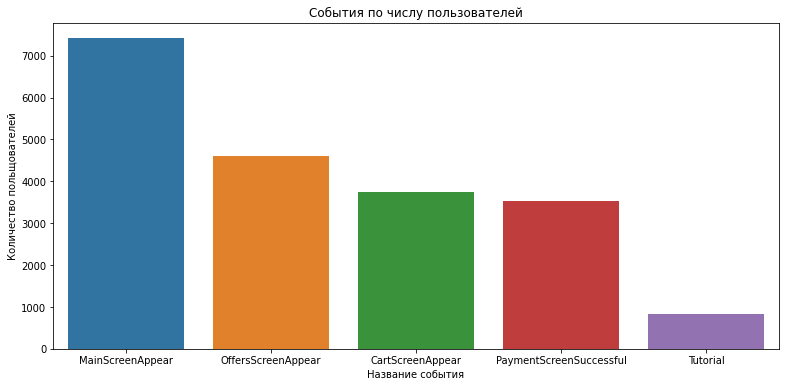

In [26]:
#Строим гистограмму событий по числу пользователей(так называемая воронка)
plt.figure(figsize=(13,6))
sns.barplot(x=user_per_event.index,y=user_per_event['device_id'])
plt.title("Cобытия по числу пользователей")
plt.xlabel("Название события")
plt.ylabel("Количество польщователей")
plt.show()

Лидирующую пазицию занимает событие MainScreenAppear с количеством событий более 7 тыс. Её и будем считать началом воронки. Далее расположились все остальные события с существенными потерями по числу пользователей(практически 50%).

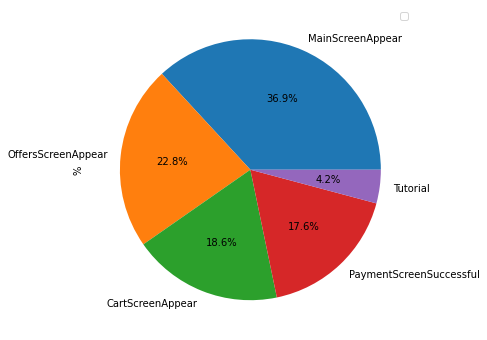

In [27]:
user_per_event.plot( y='%', kind = 'pie', autopct='%.1f%%', figsize=(10,6))
plt.legend('')
plt.show()

Предположим что события, исходя из количества пользователей прошедших эти события происходят в следущем порядке: 
<br>1.Появление главного экрана</br>
<br>2.Появление экрана предложений</br>
<br>3.Появление экрана корзины</br>
<br>4.Экран оплаты успешно</br>
<br>5.Обучение</br>

<br>Думаю событие обучение, является не объязательным на саёте и только 4% пользователей его используют.  Возможно, пользователя учат работать с сайтом. Это событие не  нужно учитывать при расчёте воронки </br>


In [28]:
#Посчитаем какая доля пользователей проходит на следующий шаг воронки(от числа пользователей на предыдущем). 
#То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B 
#к количеству пользователей с событием A, а также отношение числа пользователей с событием C 
#к количеству пользователей с событием B.
user_per_event['conversion'] = 0
for i in range(len(user_per_event['%'])):
    if i == 0:
        user_per_event['conversion'].iloc[i] = 100
    else:
        user_per_event['conversion'].iloc[i] = round(int(user_per_event['device_id'].iloc[i]) / int(user_per_event['device_id'].iloc[i-1]), 2)*100
user_per_event

,device_id,%,conversion
event_name,,,
MainScreenAppear,7419,98.5,100
OffersScreenAppear,4593,61.0,62
CartScreenAppear,3734,49.6,81
PaymentScreenSuccessful,3539,47.0,95
Tutorial,840,11.1,24


На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей.

Большее количество пользователей теряется на этапе перехода от главного экрана к экрану с предложением. Потери составляют 38%, когда на следующих этапах "отсеивается" не более 20%.

In [29]:
ratio = round(int(user_per_event['device_id'].iloc[3]) / int(user_per_event['device_id'].iloc[0]), 2)*100
print('На экран с оплатой заказа переходят:',ratio,'% пользователей по отношению к главной странице сайта.')

На экран с оплатой заказа переходят: 48.0 % пользователей по отношению к главной странице сайта.


<b>Изучаем результаты эксперимента</b>

In [30]:
#Посмотрим сколько пользователей в каждой экспериментальной группе
users_group = сomplete_data.pivot_table(index='group_id', values='device_id',aggfunc='nunique')
users_group

,device_id
group_id,
246,2484
247,2513
248,2537


В каждой группе почти по 2500 пользоватлей.

In [31]:
# Собираем все необходимые данные в один датасет, для удобства анализа 
all_events_user = сomplete_data.pivot_table(index='group_id',columns = 'event_name' ,values='device_id',aggfunc='nunique')
del all_events_user['Tutorial'] # Удаляем данное событие из таблицы, т.к. ранее выяснили что оно не имеет отношения к воронке

#Добавляю столбец с общим количеством пользователей из каждой экспериментальной группы.
all_events_user['all_users_in_group'] = users_group['device_id']
#Считаем долю пользователей, совершивших событие MainScreenAppear(самое популярное) от общего числа пользователей 
all_events_user['share_of_users'] = round(all_events_user['MainScreenAppear']/all_events_user['all_users_in_group']*100,2)
all_events_user

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,all_users_in_group,share_of_users
group_id,,,,,,
246,1266,2450,1542,1200,2484,98.63
247,1238,2476,1520,1158,2513,98.53
248,1230,2493,1531,1181,2537,98.27


Сформулируем гипотезы:
<br>H0:Между контрольными группами нет стат. значимости</br>
<br>H1:Между группами присутствует стат. значимость</br>
<br>Тесты будем проверять z-критерием</br>

In [32]:
#Выставим критический уровень стат. значимости
alpha = 0.05  # критический уровень статистической значимости

Разница в конверсии между двумя группами с конверсиями 46 и 48% оказалась не значимой.

In [33]:
# Напишем функцию для проверки гипотез 
def return_hypothesis_test(success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', round(p_value,2))
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [34]:
# Напишем функцию, которая определяет порядковый номер группы и возвращает результаты проверки гипотез первой функции
def definition_of_values(group_1, group_2): 
    all_users = ([all_events_user['all_users_in_group'][group_1], all_events_user['all_users_in_group'][group_2]]) 
    MainScreenAppear = ([all_events_user['MainScreenAppear'][group_1], all_events_user['MainScreenAppear'][group_2]])
    OffersScreenAppear = ([all_events_user['OffersScreenAppear'][group_1], all_events_user['OffersScreenAppear'][group_2]])
    CartScreenAppear = ([all_events_user['CartScreenAppear'][group_1], all_events_user['CartScreenAppear'][group_2]])
    PaymentScreenSuccessful = ([all_events_user['PaymentScreenSuccessful'][group_1], all_events_user['PaymentScreenSuccessful'][group_2]])
    
    print('Результаты теста по долям all_users и MainScreenAppear для групп')
    return_hypothesis_test(MainScreenAppear, all_users, alpha)
    
    print('Результаты теста по долям OffersScreenAppear и all_users для групп')
    return_hypothesis_test(OffersScreenAppear, all_users, alpha)
    
    print('Результаты теста по долям all_users и CartScreenAppear для групп')
    return_hypothesis_test(CartScreenAppear, all_users, alpha)
    
    print('Результаты теста по долям PaymentScreenSuccessful и all_users для групп')
    return_hypothesis_test(PaymentScreenSuccessful, all_users, alpha)

In [35]:
#Вызовим функцию и передадим ей значения групп 246 и 247
definition_of_values(0,1)

Результаты теста по долям all_users и MainScreenAppear для групп
p-значение:  0.76
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear и all_users для групп
p-значение:  0.25
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям all_users и CartScreenAppear для групп
p-значение:  0.23
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful и all_users для групп
p-значение:  0.11
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Согласно проверки 246 и 247 группы по всем событиям воронки не имеют различий. Все значения p-value, выше критического уровня стат значимости. Это значит что: <br>на результаты не влияют аномалии и выбросы в генеральной совокупности;</br>
<br>инструмент «деления» трафика работает безошибочно;</br>
<br>данные отправляются в системы аналитики корректно.</br>

<b>Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.</b>

In [36]:
#У нас есть готовая таблица со всеми необходимыми данными, нужно добавить значения по объединению двух групп 246 и 247
#Данные понадобятся для сравнения с 248 группой(изменённый шрифт)
all_events_user.loc['246_247'] = [all_events_user['CartScreenAppear'][0]+all_events_user['CartScreenAppear'][1],
                        all_events_user['MainScreenAppear'][0]+all_events_user['MainScreenAppear'][1],
                        all_events_user['OffersScreenAppear'][0]+all_events_user['OffersScreenAppear'][1],
                        all_events_user['PaymentScreenSuccessful'][0]+all_events_user['PaymentScreenSuccessful'][1],
                        all_events_user['all_users_in_group'][0]+all_events_user['all_users_in_group'][1],  
                        all_events_user['share_of_users'][0]+all_events_user['share_of_users'][1]]         
                                 
                        

In [37]:
#Сравним группу 246 и 248 по всем событиям 
#Вызовем уже готовую функцию и передадим индексы необходимых нам групп 0 и 2
definition_of_values(0,2)

Результаты теста по долям all_users и MainScreenAppear для групп
p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear и all_users для групп
p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям all_users и CartScreenAppear для групп
p-значение:  0.08
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful и all_users для групп
p-значение:  0.21
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
#Сравним группу 247 и 248 по всем событиям 
#Вызовем уже готовую функцию и передадим индексы необходимых нам групп 1 и 2
definition_of_values(1,2)

Результаты теста по долям all_users и MainScreenAppear для групп
p-значение:  0.46
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear и all_users для групп
p-значение:  0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям all_users и CartScreenAppear для групп
p-значение:  0.58
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful и all_users для групп
p-значение:  0.74
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
#Сравним группу 246_247 и 248 по всем событиям 
#Вызовем уже готовую функцию и передадим индексы необходимых нам групп 3 и 2
definition_of_values(3,2)

Результаты теста по долям all_users и MainScreenAppear для групп
p-значение:  0.29
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear и all_users для групп
p-значение:  0.43
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям all_users и CartScreenAppear для групп
p-значение:  0.18
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful и all_users для групп
p-значение:  0.6
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<b>Промежуточный итог</b>

1)Выбрал уровень значимости 0.05.
<br>2)Всего проверок совершено 17</br>
<br>3)Если мы имеем всего 17 проверок а при значимости в 0.1 есть вероятность возникновения ошибки равной 1 к 10. то следует применять уровень меньше 0.1 в моём случае пименялся уровень 0.05. Из этого можно сделать вывод что ошибка может возникнуть куда реже т.е. 1 к 20</br>

<b>Общий вывод</b>

Согласно всех проведённых тестов между контрольными группами 246 247 и 248. Статистически значемых различий не было обнаружено. Единственный показатель p-value был чуть выше у контрольной группы 246 по событию CartScreenAppear и был равен 0.08 по сравнению с контрольной группой 248. Из этого следует что изменение шрифта во всём приложениии не повлияли на рекцию пользователей. Рекомендую обратить внимание на результаты тестов и не боясь за реакцию пользователей поменять шрифт во всём приложении, если в этом есть необходимость.

Что косается воронки продаж то события складываются в следущем порядке. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты. <br><b>Предположительно, воронка продаж следующая:</b></br>

<br>пользователь видит главныф экран сайта </br>

<br>пользователь переходит на понравившийся ему товар</br>

<br>пользоватеь добавляет товар в корзину и переходит в нее
</br>

<br>пользователь оплачивает заказ</br>

<br><b>Кол-во пользователей/ % перехода пользователей с одного события к другому/конверсия пользователей:</b></br>

<br>главный экран сайта:<br>кол-во пользователей 7419,</br> <br>% перехода к след событию 98.5,</br> <br>конверсия пользователей 100 %</br></br>

<br>переход на понравившийся товар:</br> <br>кол-во пользователей 4593,</br> <br>% перехода к след событию 61.0,</br><br> конверсия пользователей 62 %</br>

<br>переход в корзину:</br><br> кол-во пользователей 3734,</br> <br>% перехода к след событию 49.6,</br> <br>конверсия пользователей 81 %
</br>

<br>оплата заказа:</br> <br>кол-во пользователей 3539,</br> <br>% перехода 47.0,</br><br> конверсия пользователей 95 %</br>

Судя по данным можно утвержать что самая большая потеря пользователей приходится на этап перехода пользователей с главного экрана на экран понравившегося товара он составляет практически 40 %. А самая минимальная потеря с экрана корзины к экрану оплаты товара которая ровна 5%. Из общей картины конверсии в исследовании выяснили что всего примерно 49 % пользователей с главного экрана переходят на экран оплаты товара. 